# Ejercicio 1


In [123]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import lfilter, periodogram, freqz, correlate
import soundfile as sf
from scipy.fft import fft
from scipy.signal import freqz, lfilter
import sounddevice as sd
from utils import densidadEspectralPotenciaAR, reproducir , gen_pulsos , psd_pulsos ,suavizar_bordes 
from data import coef_a, coef_b


Se dispone del archivo “data.py” que contiene los diccionarios con los
coeficientes “coef b” y “coef a” del proceso AR (P = 20) que modela cada uno de los audios
provistos.

In [124]:
fs = 14700 # tomamos 14700 muestras por segundo de nuestra grabacion 
#asumimos procesos estacionarios
colors2 = ['#1D452E', '#3685B5', '#73A580', '#3BA99C', '#7EBCE6']
colors3 = [ "#011936", "#3685B5",  "#3BA99C",  "#109139", "#033312", "#8C1A6A", "#A657AE", "#A71D31", "#804E49"]
colors4 = ["#000100", "#230C33", "#592E83", "#9984D4", "#CAA8F5", "#C32F27", "#D8572A", "#DB7C26", "#F7B538"]
colors44 = ["#C32F27", "#D8572A", "#DB7C26", "#F7B538", "#FFC971", "#8C1A6A", "#A657AE", "#230C33", "#592E83"]
colors=[ "#230C33", "#592E83", "#9984D4", "#A657AE", "#8C1A6A", "#C32F27", "#D8572A", "#DB7C26", "#F7B538"]
"""
FFC971
fríos (azules/ verdes): "#011936", "#465362", "#3685B5", "#9FC490", "#3BA99C",
rosas: "#8C1A6A", "#A657AE", "#A71D31", "#804E49"
"""
audios_vocales = ['a.wav', 'e.wav', 'i.wav', 'o.wav', 'u.wav']
audios_consonantes = ['f.wav', 's.wav', 'j.wav', 'sh.wav']

fonemas = ['a', 'e', 'i', 'o', 'u', 'sh', 'f', 's', 'j']

N = int(0.2 * fs) #nos quedamos solo con las muestras q corresponden a los 200ms 

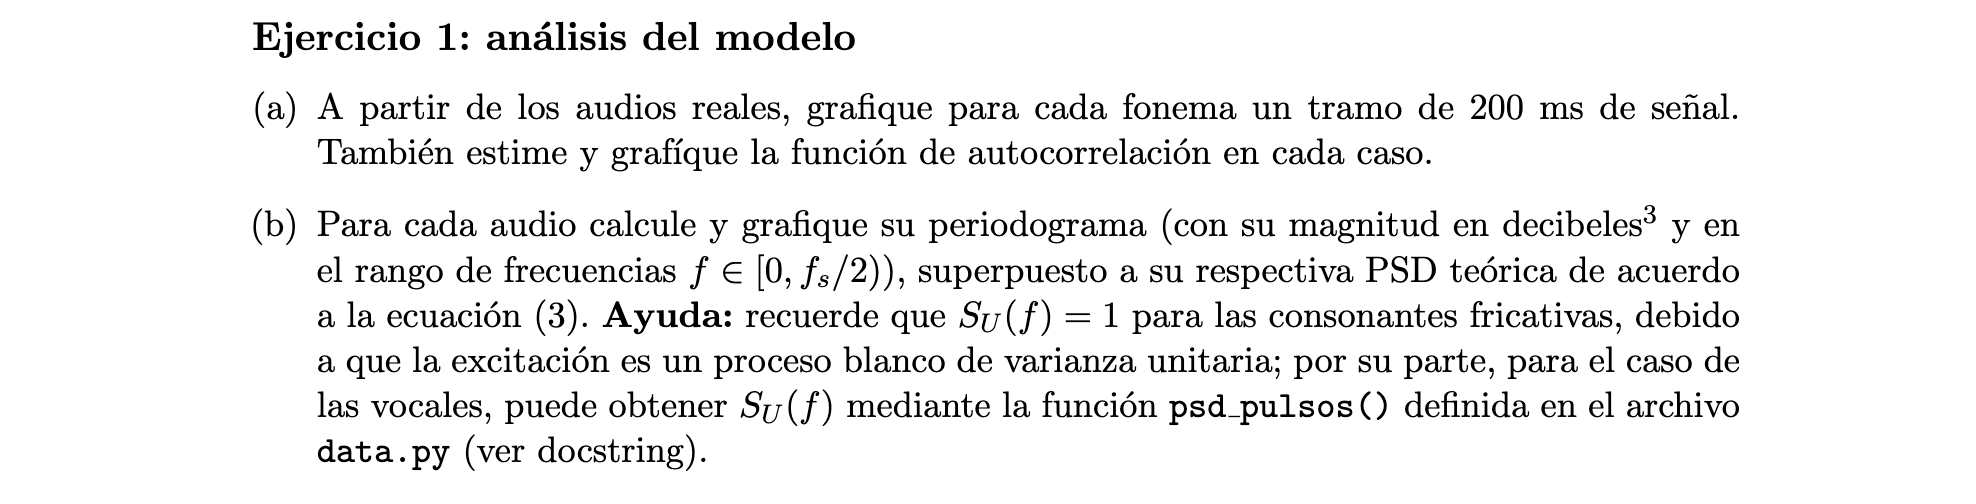

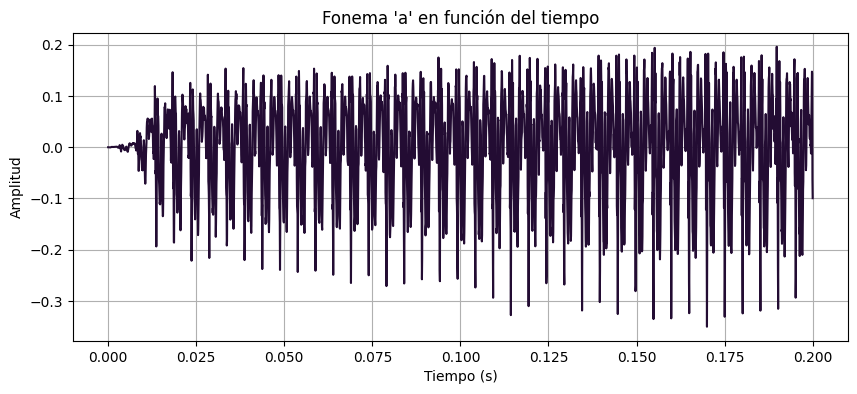

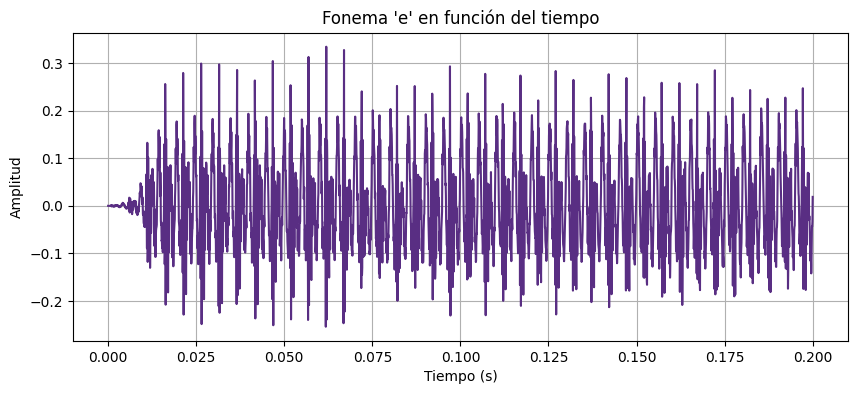

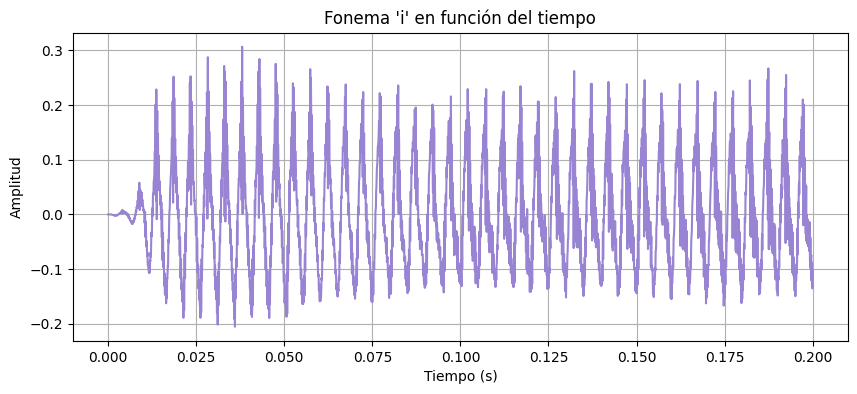

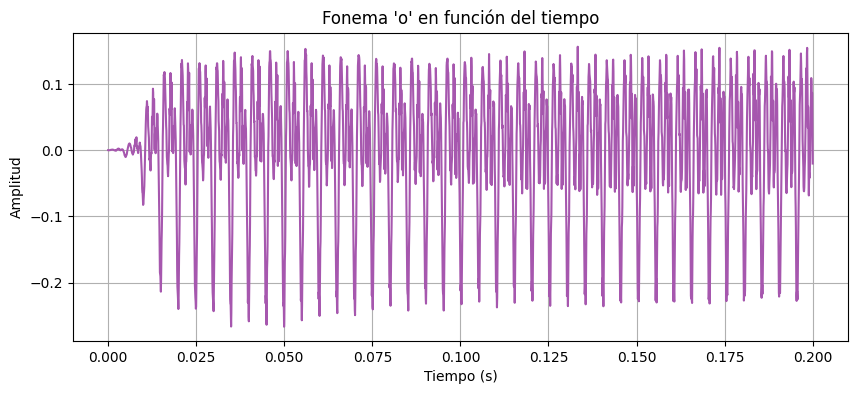

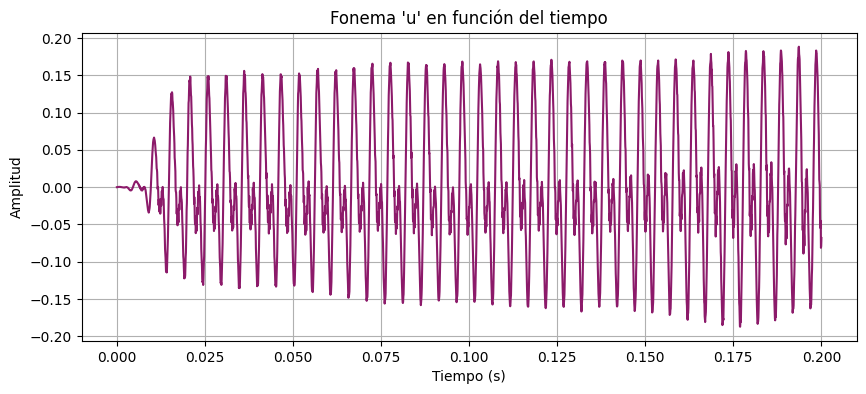

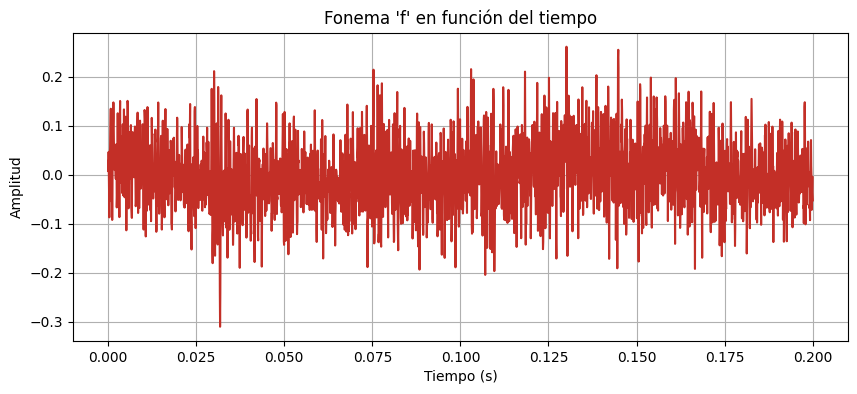

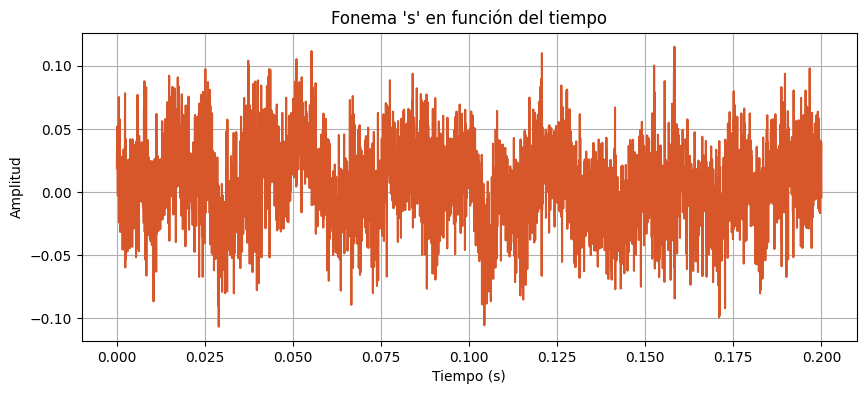

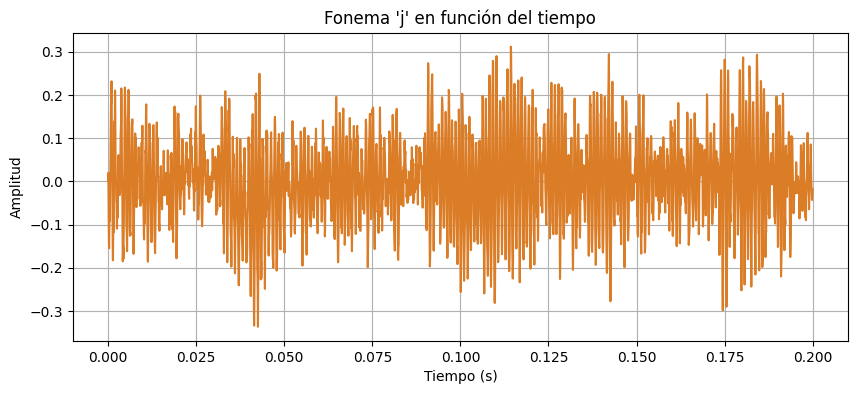

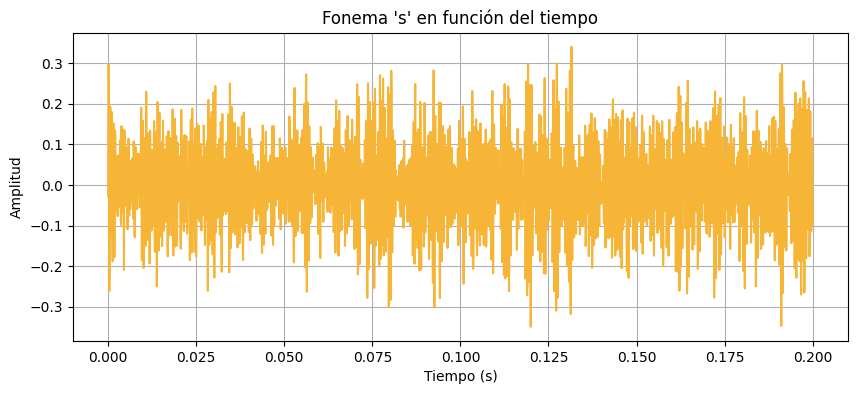

In [125]:
#a) graficar fonemas
tramos = [] 
audios = []
for idx,i in enumerate(audios_vocales + audios_consonantes):
    audio, _ = sf.read(i)
    audios.append(audio)

    tramo = audio[:N] # tomamos solo los primeros 200ms
    tramos.append(tramo)
    time = np.linspace(0, 0.2, len(tramo))

    plt.figure(figsize=(10, 4))

    plt.plot(time, tramo, colors[idx % len(colors)])
    plt.title(f"Fonema '{i[0]}' en función del tiempo")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

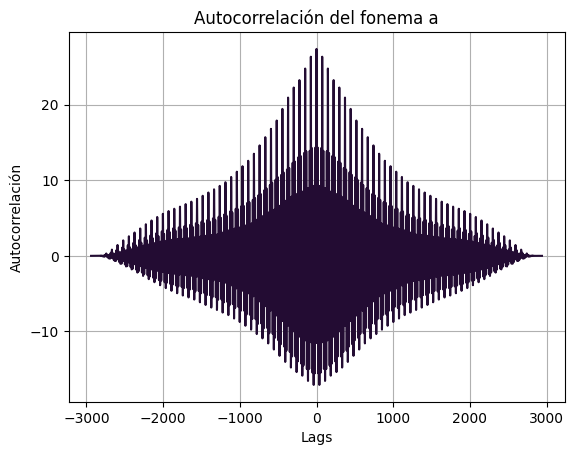

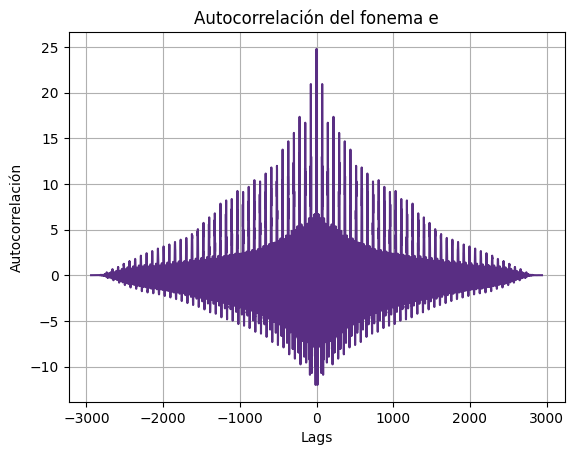

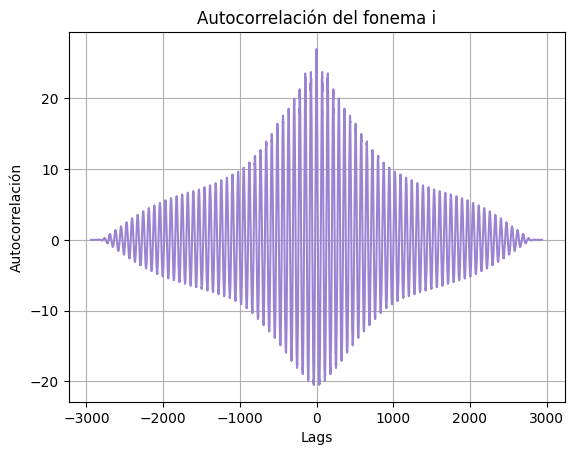

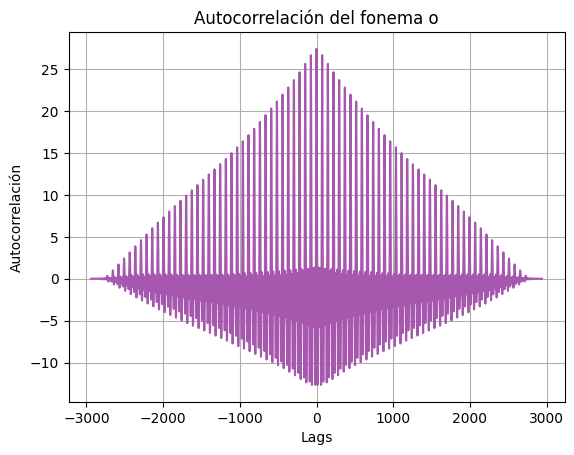

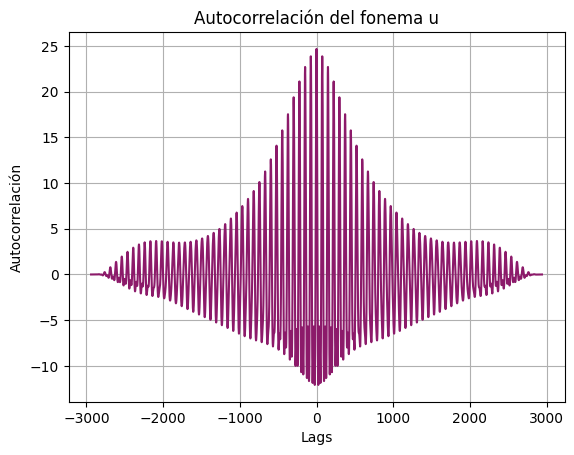

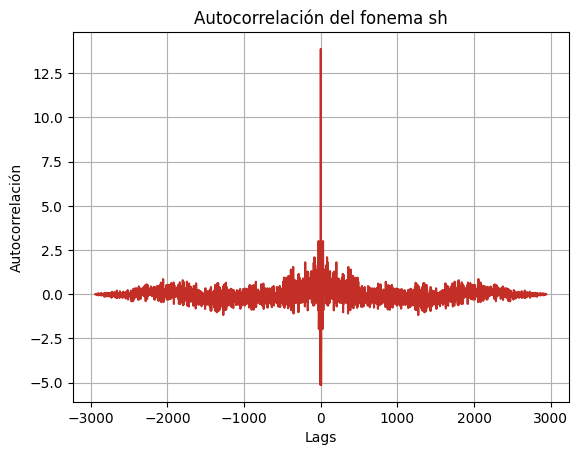

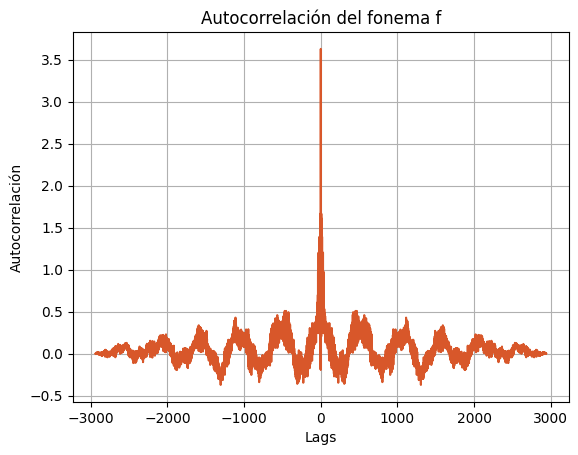

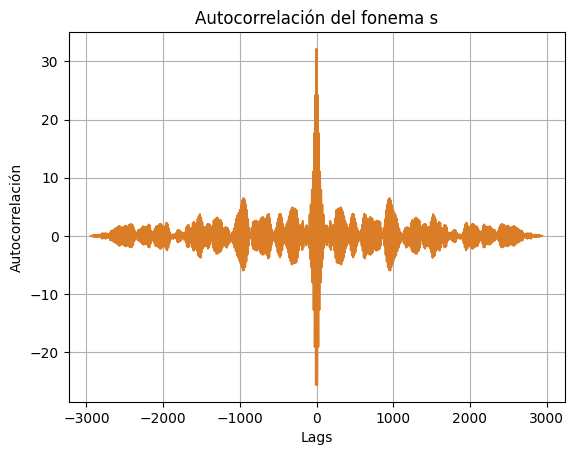

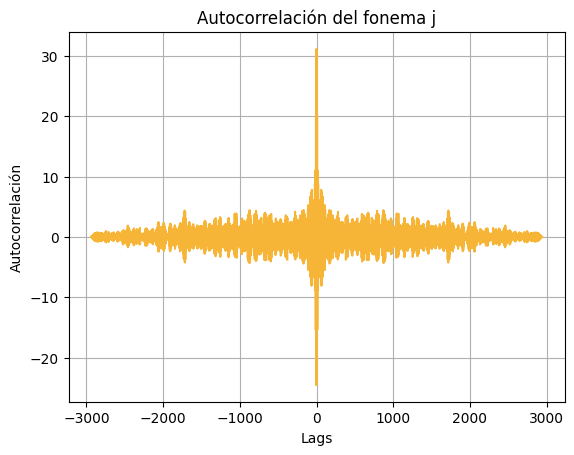

In [126]:
#a) estimar + graficar autocorr

def graficar_autocorrelacion(tramo, fonema, color):
    autocorrelacion = correlate(tramo, tramo, mode='full')
    lags = np.arange(-len(tramo) + 1, len(tramo))
    plt.plot(lags, autocorrelacion, color)
    plt.title(f"Autocorrelación del fonema {fonema}")
    plt.xlabel("Lags")
    plt.ylabel("Autocorrelación")
    plt.grid()
    plt.show()


for i in range(len(fonemas)):
    graficar_autocorrelacion(tramos[i], fonemas[i], colors[i % len(colors)])


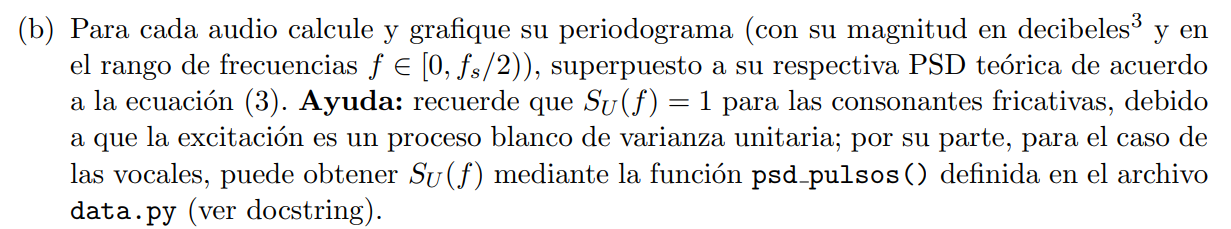

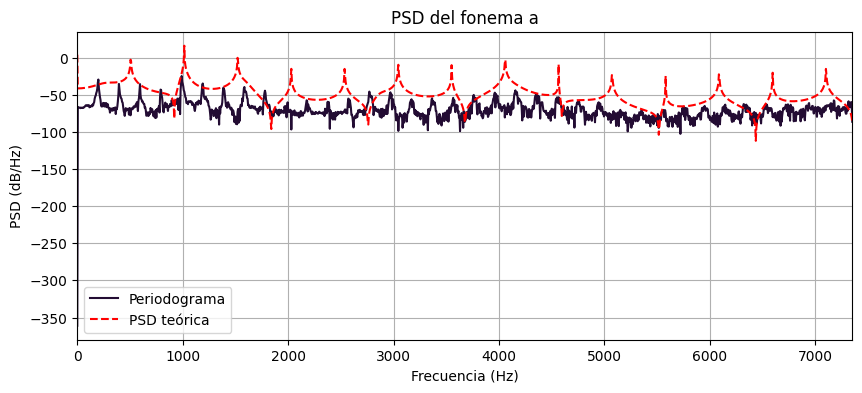

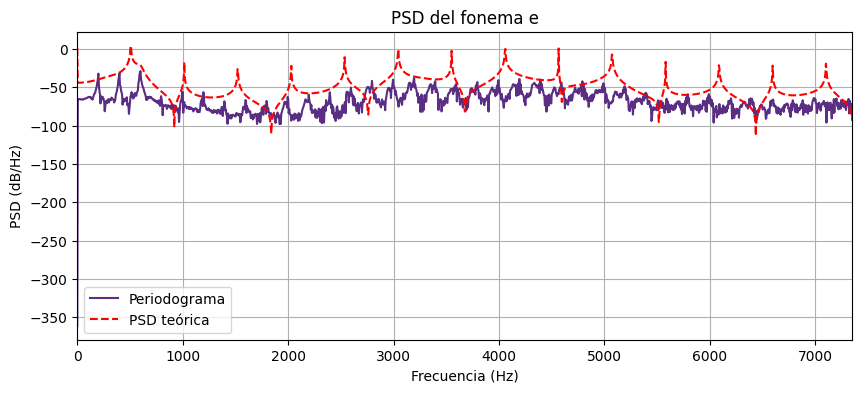

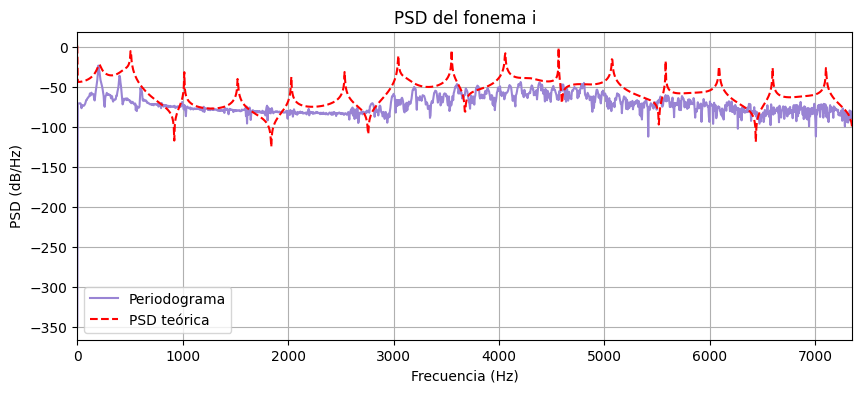

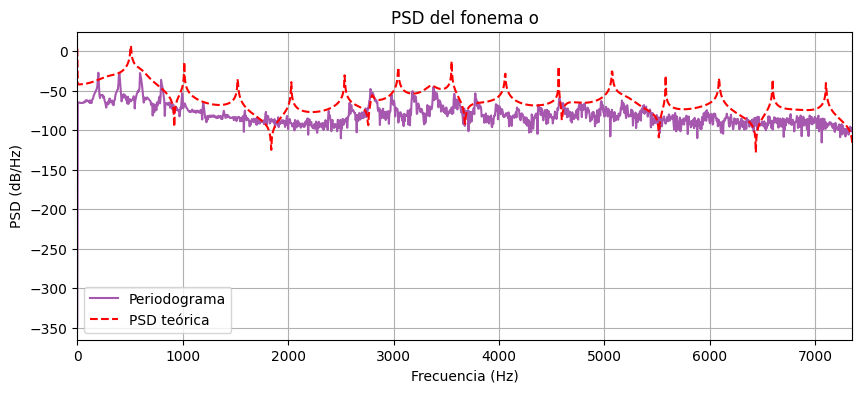

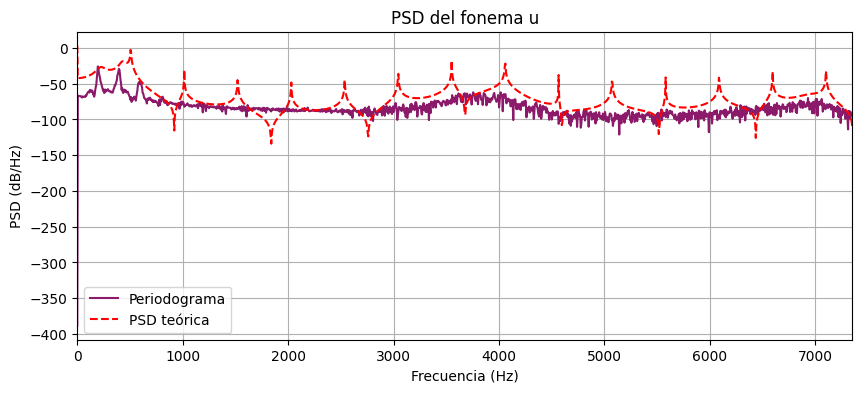

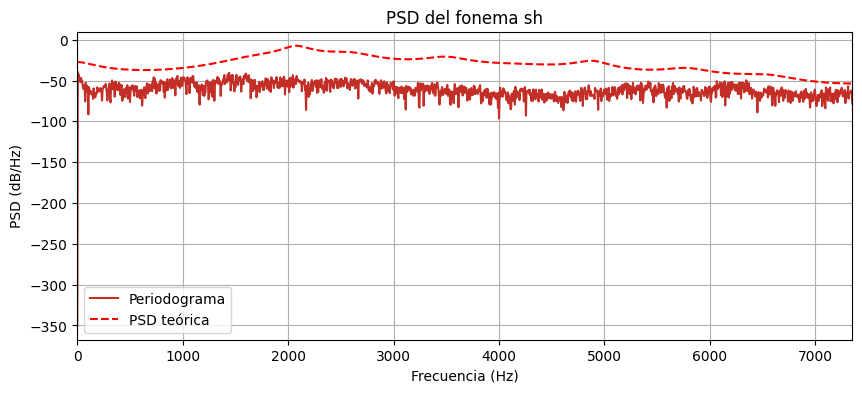

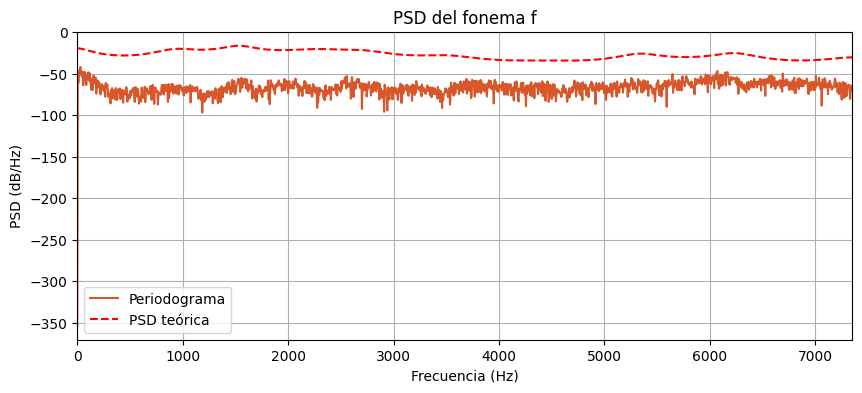

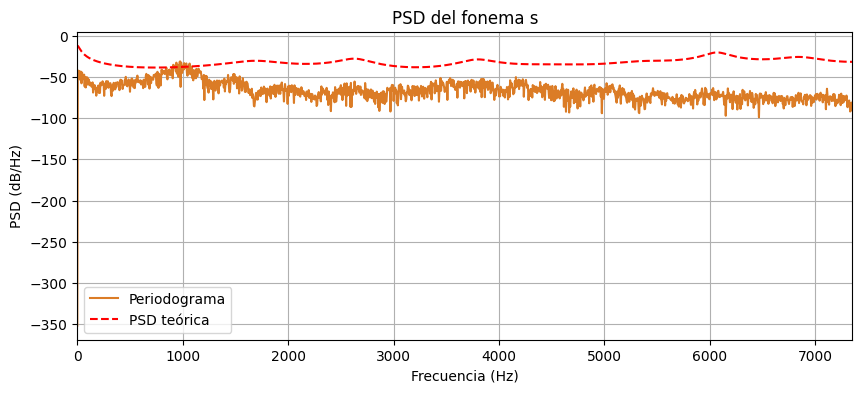

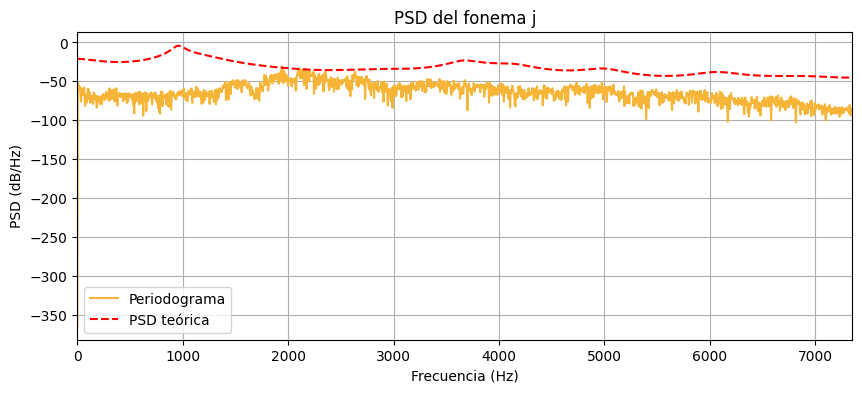

In [127]:
for i, tramo in enumerate(tramos):
    fonema = fonemas[i]
    f, Pxx = periodogram(tramo, fs, scaling='spectrum')
    plt.figure(figsize=(10, 4))
    plt.plot(f, 10 * np.log10(Pxx), label="Periodograma", color=colors[i])

    coef_a_fonema = np.array(coef_a[fonema])  # los casteamos para pasarlo a la funcion
    coef_b_fonema = coef_b[fonema][0]         
    
    if fonema in ['f', 's', 'j', 'sh']:
        S_U = np.ones_like(f) # para las consonantes, S_U = 1 (ruido blanco)
        S_X_teorica = densidadEspectralPotenciaAR(coef_a_fonema, coef_b_fonema, f, S_U, fs) #S_X = |H(f)|² × S_U
        plt.plot(f, 10 * np.log10(S_X_teorica), 'r--', label="PSD teórica")
    else: # no se si las frecuencias que comparmao son las mismas y habri que interpolar. 
        f0 = 500
        Su, f_pulsos = psd_pulsos(f0, len(f)*2, fs)  # generamos el especto de pulsos completo
        S_U = Su[:len(f)]  # solo tomamos la mitad para comparar con luego con  el periodograma
        f_pulsos = f_pulsos[:len(f)]  # solo tomamos la mitad para comparar con luego con  el periodograma
        S_X_teorica = densidadEspectralPotenciaAR(coef_a_fonema, coef_b_fonema, f, S_U, fs) # S_X = |H(f)|² × S_U 
        plt.plot(f, 10 * np.log10(S_X_teorica), 'r--', label="PSD teórica")

        
    plt.title(f"PSD del fonema {fonema}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("PSD (dB/Hz)")
    plt.legend()
    plt.grid()
    plt.xlim(0, fs/2)  
    plt.show()

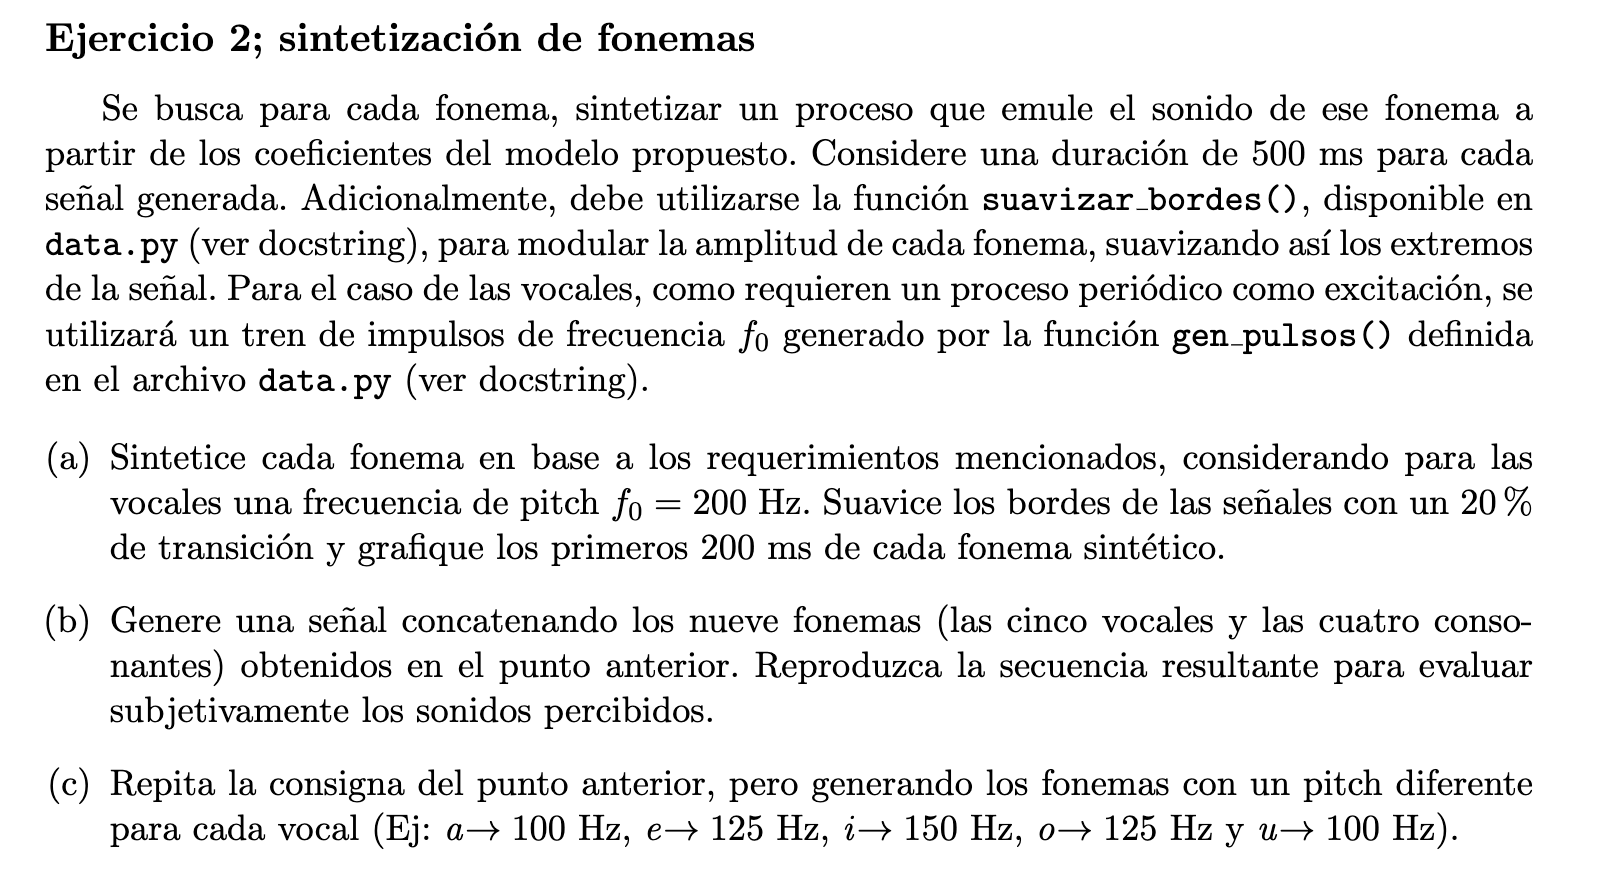

In [128]:
#lo que queremos "copiar"
for i in audios:
    reproducir(i, fs)

duracion_fonema = 0.5
N = int(duracion_fonema * fs) #piso val
f0_vocales = 200

print(fonemas[:5])

['a', 'e', 'i', 'o', 'u']


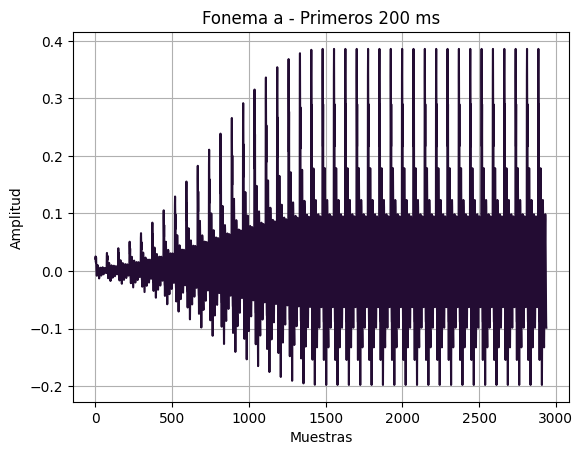

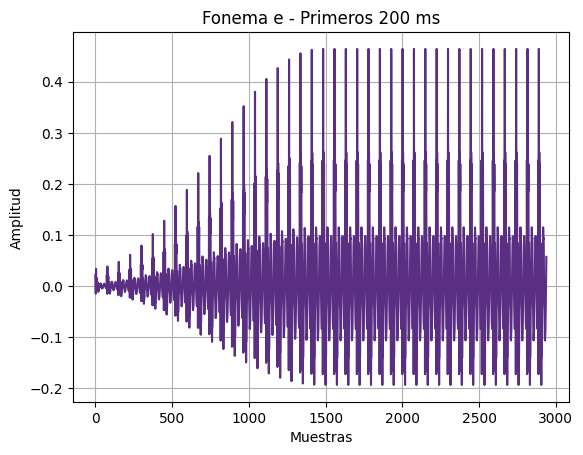

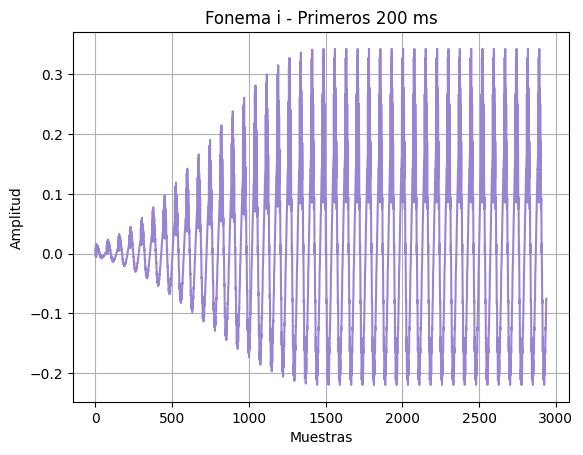

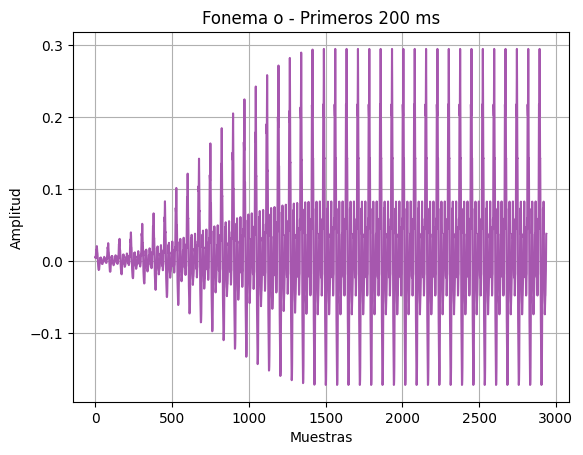

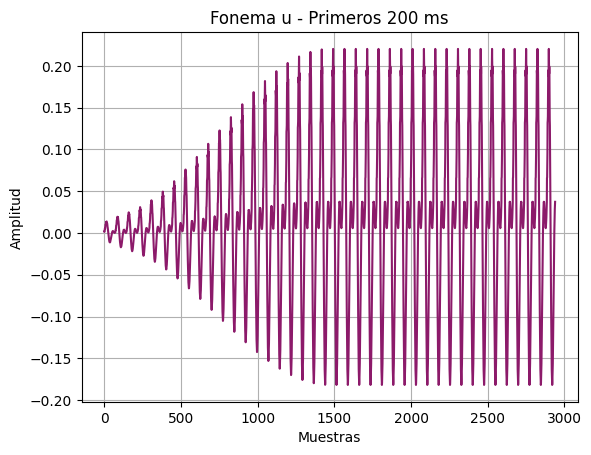

In [129]:
#a)
señales_fonemas = {}
f0_vocales = 200

for i, fonema in enumerate(fonemas):  # TODOS los fonemas
    if fonema in ['f', 's', 'j', 'sh']:
        excitacion = np.random.randn(N)  # para las consonantes usamos ruido blanco
    else:
        excitacion = gen_pulsos(f0_vocales, N, fs) # para las vocales usamos tren de pulsos
    
    b = np.array(coef_b[fonema])
    a = np.array([1.0] + [-coef for coef in coef_a[fonema]])
    
    señal = lfilter(b, a, excitacion)
    señal = suavizar_bordes(señal)
    señales_fonemas[fonema] = señal
    
    if i < 5:
        plt.figure()
        plt.plot(señal[:int(0.2 * fs)], color=colors[i])
        plt.title(f"Fonema {fonema} - Primeros 200 ms")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.grid()
        plt.show()

In [130]:
señales_ordenadas = [señales_fonemas[fonema] for fonema in fonemas]
señal_concatenada = np.concatenate(señales_ordenadas)
sd.play(señal_concatenada, fs)

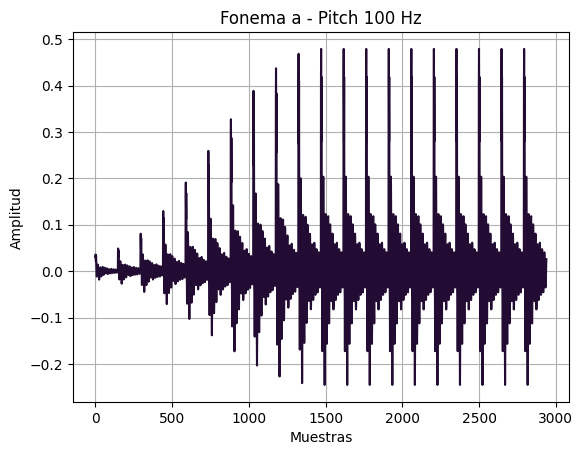

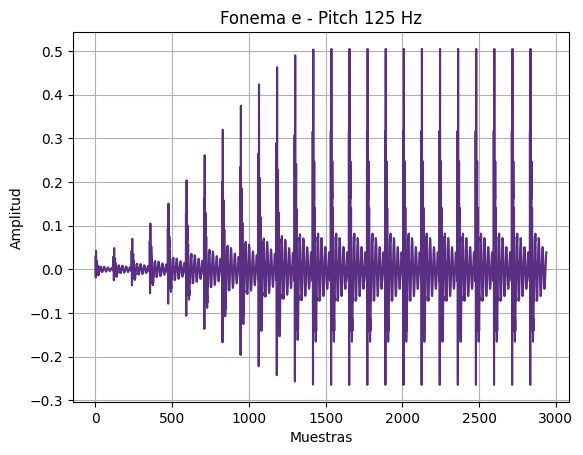

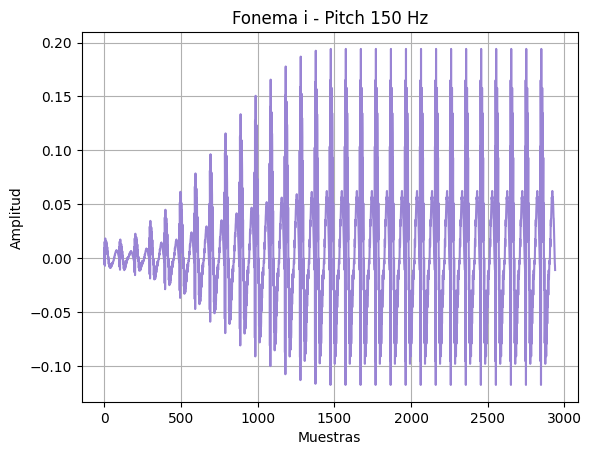

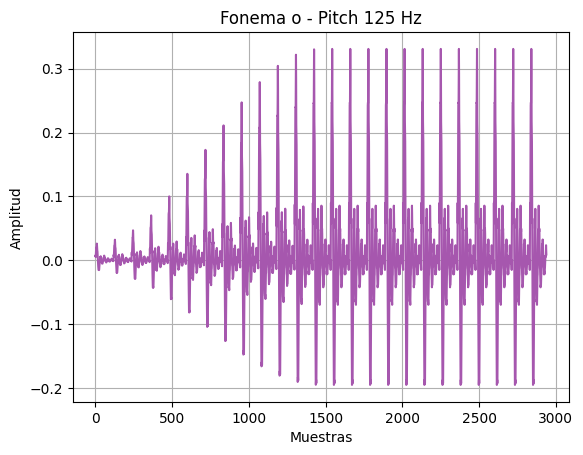

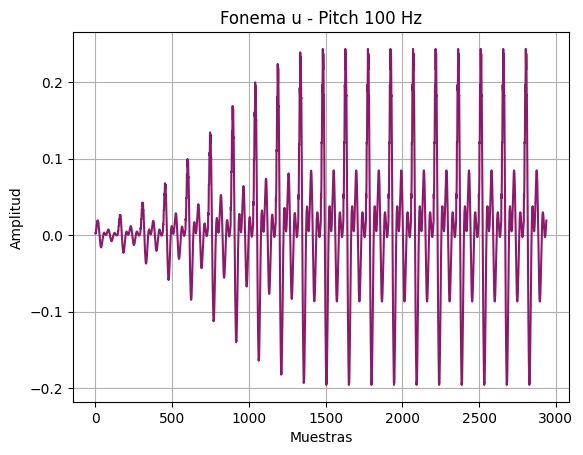

In [131]:
# c) diferentes pitch para cada vocal
pitch_vocales = {
    'a': 100,  
    'e': 125,    
    'i': 150,  
    'o': 125,  
    'u': 100   
}

señales_fonemas_pitch = {}

for i, fonema in enumerate(fonemas):
    if fonema in ['f', 's', 'j', 'sh']:
        excitacion = np.random.randn(N)
    else:
        f0 = pitch_vocales[fonema]  
        excitacion = gen_pulsos(f0, N, fs)
    
    b = np.array(coef_b[fonema])
    a = np.array([1.0] + [-coef for coef in coef_a[fonema]])
    
    señal = lfilter(b, a, excitacion)
    señal = suavizar_bordes(señal)
    señales_fonemas_pitch[fonema] = señal

    if i < 5:
        plt.figure()
        plt.plot(señal[:int(0.2 * fs)], color=colors[i])
        plt.title(f"Fonema {fonema} - Pitch {pitch_vocales.get(fonema, 'N/A')} Hz")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.grid()
        plt.show()

señales_ordenadas_pitch = [señales_fonemas_pitch[fonema] for fonema in fonemas]
señal_concatenada_pitch = np.concatenate(señales_ordenadas_pitch)
sd.play(señal_concatenada_pitch, fs)